# OIE Model

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
%config Completer.use_jedi = False

In [3]:
# import data from florian
data_df = pd.read_csv('./PADH_sample_set.csv')
data_df = data_df[['Tag', 'OIE ‰', 'infected ‰', 'Hb (g/l)', 'Retis ‰']]


In [4]:
data_df.head()

,Tag,OIE ‰,infected ‰,Hb (g/l),Retis ‰
0,1.0,35.849057,391.644205,9.6,NaN
1,NaN,NaN,NaN,NaN,NaN
2,3.0,199.074074,87.268519,8.1,NaN
3,4.0,350.279330,0.000000,7.6,13.3
4,NaN,NaN,NaN,NaN,NaN


## Model introduction


![model scheme](model_scheme.png)

In [5]:
import numpy as np
import tellurium as te

In [6]:
half_life_E = 100/2 # days
k_death = np.log(2) / half_life_E

E_tot = 5e6  # cells per µl
replaced_E_per_day = 5e4
# k_age * R in steady state = 5e4
R_percent = 1
R_ss = E_tot * R_percent / 100
E_ss = E_tot - R_ss

# set k_death such that 5e4 die per day
k_death = replaced_E_per_day / E_ss
k_age = replaced_E_per_day / R_ss
# k_birth * 1 / (1 + (E + R) / KI) == 5e4; has to be same rate as k_age * R in steady state
# assume that rate is at 10% of maximal speed (KI = (E + R) / 9)
KI = (E_ss + R_ss) / 9
k_birth = replaced_E_per_day * (1 + (E_ss + R_ss) / KI)

# plasmodium infection
parasitemia = 0.4
half_life_parasite = 0.75 # days, defined by rates k_recover and k_removal
k_recover_frac = 0.9
k_IE_death = np.log(2) / half_life_parasite
k_recover = k_IE_death * k_recover_frac
k_removal = k_IE_death * (1 - k_recover_frac)

half_life_OIE = 7
k_death2 = np.log(2) / half_life_OIE

# assumption for activation of E degradation, degradation activated by parasitemia
# ==> p = IE / (R + E + IE + OIE) assume maximal extra degradation rate equals default degradation rate
k_deg_par = k_death * 0.5
# assume that at 20 % parasitemia rate is half maximal
Km_Ery_deg = 0.2

print(f'E: {E_ss}\nR: {R_ss}\nk_age: {k_age}\nk_death: {k_death}\nKI: {KI}\nk_birth: {k_birth}\nk_recover: {k_recover}\nk_removal: {k_removal}\n\
k_death2: {k_death2}\nk_deg_par: {k_deg_par}')
print(1 / (1 + (E_ss + R_ss) / KI) * k_birth, R_ss * k_age, E_ss * k_death)

E: 4950000.0
R: 50000.0
k_age: 1.0
k_death: 0.010101010101010102
KI: 555555.5555555555
k_birth: 500000.0
k_recover: 0.8317766166719344
k_removal: 0.09241962407465935
k_death2: 0.09902102579427789
k_deg_par: 0.005050505050505051
50000.0 50000.0 50000.00000000001


In [7]:
OIE_model = """
# Species initialization
E = 4950000;
R = 50000;
IE = 0;
OIE = 0;
new_E = 0;
new_E_no_inf = 0;

# Parameter Initialization
k_birth = 500000;
k_age = 1;
k_death = 0.010001000100010001;
k_removal = 0.09241962407465935;
k_recover = 0.8317766166719344;
k_death2 = 0.09902102579427789;
k_deg_par = 0.3
R_init = 500

E_Vol = 80e-15 # 80 fL
OIE_Vol = 50e-15
Reti_Vol = 100e-15
IE_Vol = 80e-15
Hb_conc = 5.5e-3 
Hb_conc_IE = 3e-3
Hb_conc_OIE = 1.65e-3 
Hb_conc_reti = 0
molecular_mass = 64456 # g / mol
vol = 1e-6 # 1µl 

# Assignment Rules
haematocrit             := (E_Vol * E + IE_Vol * IE + OIE_Vol * OIE + Reti_Vol * R) / vol #0.4 # 40 %
hemoglobin_content      := molecular_mass * ((E_Vol * E * Hb_conc + IE_Vol * IE * Hb_conc_IE + OIE_Vol * OIE * Hb_conc_OIE + Reti_Vol * R * Hb_conc_reti) / vol) # g/l
new_hemoglobin          := molecular_mass * E_Vol * new_E * Hb_conc / vol
new_hemoglobin_noinf    := molecular_mass * E_Vol * new_E_no_inf * Hb_conc / vol
hemoglobin_content_g_dl := hemoglobin_content / 10 # g/dl

KI = 555555.5555555555;
Km_deg = 0.02;

p := IE / (E + R + IE + OIE)

# Events
#at (time>10): IE=E * p, E=E-E * p

# Reactions
Rbirth:       -> R;       k_birth * (1 / (1 + (E + R) / KI));
Raging:     R -> E;       R * k_age;
RnewE:        -> new_E;   R * k_age
RnewE_no_inf: -> new_E_no_inf; R_init * k_age
REdeaht:    E -> ;        k_death * E + k_deg_par * E * (p / (Km_deg + p));
Rremove:   IE -> ;        k_removal * IE;
Rrecover:  IE -> OIE;     k_recover * IE;
ROIEdeath: OIE-> ;        k_death2 * OIE;
"""

In [8]:
OIE = te.loada(OIE_model)
OIE.exportToSBML('./OIE.xml')

In [9]:
res = OIE.simulate(0, 10)

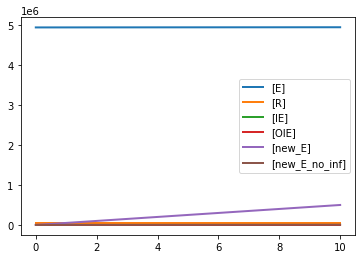

In [10]:
OIE.plot()

In [11]:
current_E = OIE.E

# pulse parasitemia
parasitemia = 0.4
IEs = current_E * parasitemia
OIE.IE = IEs
OIE.E = current_E - IEs
OIE.new_E = 0
OIE.new_E_no_inf = 0

In [12]:
res2 = OIE.simulate(10,55)

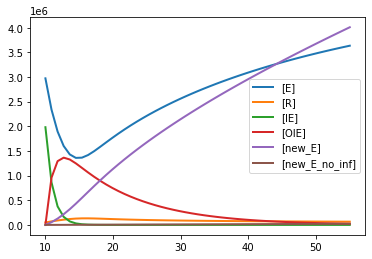

In [13]:
OIE.plot()

In [14]:
tot_res = np.vstack((res, res2))

In [15]:
time = tot_res[::, 0]
species = tot_res[::,1:]
species.shape

(102, 6)

In [16]:
import matplotlib.pyplot as plt

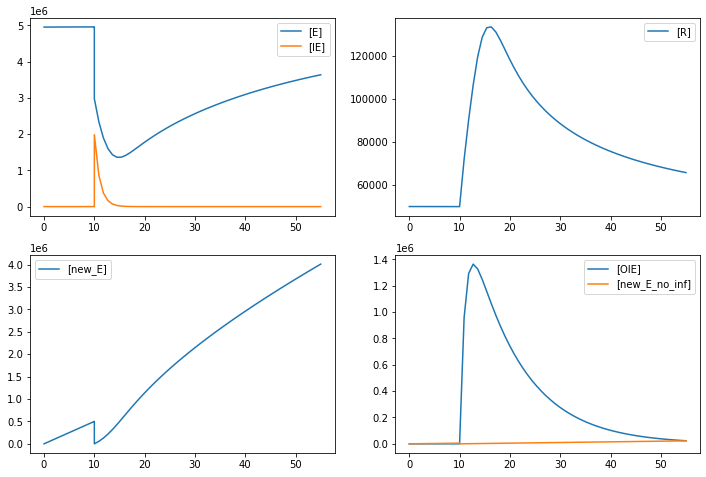

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
for i, label in enumerate(res.colnames[1:]):
    row = i // 3
    col = i % 2
    ax[row, col].plot(time, species[::, i], label=label)
    ax[row, col].legend()
plt.show()

In [18]:
print(res.colnames)

['time', '[E]', '[R]', '[IE]', '[OIE]', '[new_E]', '[new_E_no_inf]']


In [19]:
E_res = species[::, 0]
R_res = species[::, 1]
IE_res = species[::, 2]
OIE_res = species[::, 3]
new_E = species[-1, 4]
new_E_no_inf = species[-1, 5]
E_Vol = 80e-15 # 80 fL
OIE_Vol = 50e-15
Reti_Vol = 100e-15
IE_Vol = 80e-15
Hb_conc = 5.5e-3 # M
Hb_conc_IE = 3e-3
Hb_conc_OIE = 5.5e-3 * 0.3
Hb_conc_reti = 0
molecular_mass = 64456 # g / mol
vol = 1e-6 # 1µl 
haematocrit= (E_Vol * E_res + IE_Vol * IE_res + OIE_Vol * OIE_res + Reti_Vol * R_res) / vol #0.4 # 40 %
hemoglobin_content =  molecular_mass * ((E_Vol * E_res * Hb_conc + IE_Vol * IE_res * Hb_conc_IE + 
                                         OIE_Vol * OIE_res * Hb_conc_OIE + Reti_Vol * R_res * Hb_conc_reti) / vol) # g/l
new_hemoglobin = molecular_mass * E_Vol * new_E * Hb_conc / vol
new_hemoglobin_noinf = molecular_mass * E_Vol * new_E_no_inf * Hb_conc / vol
hemoglobin_content_g_dl =  hemoglobin_content / 10 # g/dl
new_hemoglobin_content = new_hemoglobin / 10
new_hemoglobin_content_noinf = new_hemoglobin_noinf / 10

print(f'New Hemoglobin: {new_hemoglobin_content}, new E: {new_E}\nNew Hemoglobin no inf: {new_hemoglobin_content_noinf}, new E noinf: {new_E_no_inf}')

New Hemoglobin: 11.370194613297263, new E: 4009145.990110683
New Hemoglobin no inf: 0.06381143999999969, new E noinf: 22499.999999999894


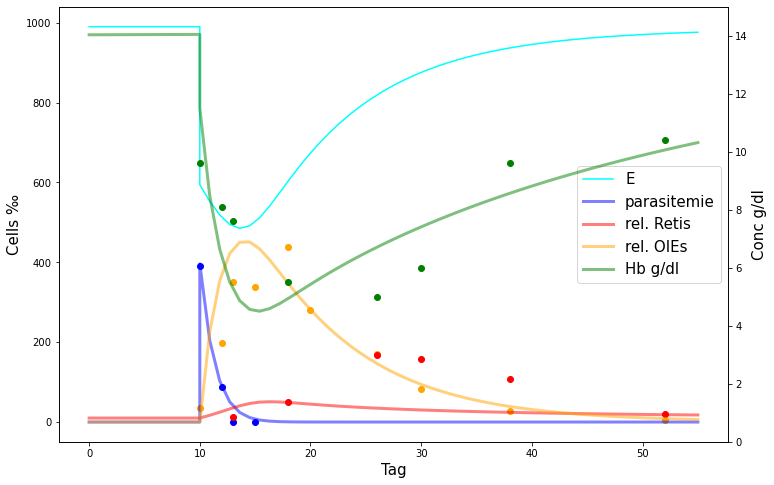

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax2 = ax.twinx()
ax.plot(time, 1e3*E_res / (IE_res + E_res + R_res + OIE_res), label='E', color='cyan')
ax.plot(time, 1e3*IE_res / (IE_res + E_res + R_res + OIE_res), label='parasitemie', color='blue', linewidth=3, alpha=0.5)
ax.plot(time, 1e3*R_res / (IE_res + E_res + R_res + OIE_res), label='rel. Retis', color='red', linewidth=3, alpha=0.5)
ax.plot(time, 1e3*OIE_res / (IE_res + E_res + R_res + OIE_res), label='rel. OIEs', color='orange', linewidth=3, alpha=0.5)
ax.scatter(data_df['Tag']+9, data_df['infected ‰'], color='blue' )
ax.scatter(data_df['Tag']+9, data_df['OIE ‰'], color='orange' )
ax.scatter(data_df['Tag']+9, data_df['Retis ‰'], color='red' )
ax2.plot(time, hemoglobin_content_g_dl, color='green', label='Hb g/dl', linewidth=3, alpha=0.5)
ax2.scatter(data_df['Tag'] + 9, data_df['Hb (g/l)'], color='green')

ax.set_xlabel('Tag', fontsize=15)
ax.set_ylabel('Cells ‰', fontsize=15)
ax2.set_ylabel('Conc g/dl', fontsize=15)
ax2.set_ylim(0, 15)

ax_handles, ax_labels = ax.get_legend_handles_labels()
ax2_handles, ax2_labels = ax2.get_legend_handles_labels()

handles = ax_handles + ax2_handles
labels = ax_labels + ax2_labels
ax.legend(handles, labels, fontsize=15)
#fig.savefig('./Ergebnisse_ohne_schnellen_Abbau_durch_IE.pdf', format='pdf')
#fig.savefig('./Ergebnisse_mit_schnellen_Abbau_durch_IE.pdf', format='pdf')

plt.show()

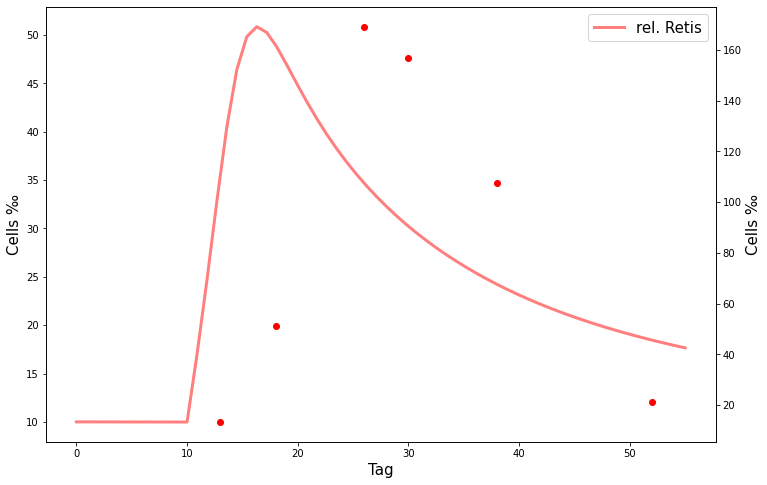

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax2 = ax.twinx()

ax.plot(time, 1e3*R_res / (IE_res + E_res + R_res + OIE_res), label='rel. Retis', color='red', linewidth=3, alpha=0.5)


ax2.scatter(data_df['Tag']+9, data_df['Retis ‰'], color='red' )


ax.set_xlabel('Tag', fontsize=15)
ax.set_ylabel('Cells ‰', fontsize=15)
ax2.set_ylabel('Cells ‰', fontsize=15)

ax_handles, ax_labels = ax.get_legend_handles_labels()
ax2_handles, ax2_labels = ax2.get_legend_handles_labels()

handles = ax_handles + ax2_handles
labels = ax_labels + ax2_labels
ax.legend(handles, labels, fontsize=15)
fig.savefig('./Retis_ohne_schnellen_Abbau_durch_IE.pdf', format='pdf')
#fig.savefig('./Retis_mit_schnellen_Abbau_durch_IE.pdf', format='pdf')

plt.show()

In [22]:
ax2_handles

[]

# OIE Model - Reti production only induced by OIE

In [23]:
half_life_E = 100 # days
k_death = np.log(2) / half_life_E

E_tot = 5e6
replaced_E_per_day = 5e4
# k_age * R in steady state = 5e4
R_percent = 0.05
R_ss = E_tot * R_percent / 100
E_ss = E_tot - R_ss

# set k_death such that 5e4 die per day
k_death = replaced_E_per_day / E_ss
k_age = replaced_E_per_day / R_ss
# k_birth * 1 / (1 + (E + R) / KI) == 5e4; has to be same rate as k_age * R in steady state
# assume that rate is at 10% of maximal speed (KI = (E + R) / 9)
KI = (E_ss + R_ss) / 9
k_birth = replaced_E_per_day * (1 + (E_ss + R_ss) / KI)

# plasmodium infection
parasitemia = 0.2
half_life_parasite = 1 # days, defined by rates k_recover and k_removal
k_recover_frac = 0.9 
k_IE_death = np.log(2) / half_life_parasite
k_recover = k_IE_death * k_recover_frac
k_removal = k_IE_death * (1 - k_recover_frac)

half_life_OIE = 7
k_death2 = np.log(2) / half_life_OIE

# assumption for activation of E degradation, degradation activated by parasitemia
# ==> p = IE / (R + E + IE + OIE) assume maximal extra degradation rate equals default degradation rate
k_deg_par = k_death
# assume that at 20 % parasitemia rate is half maximal
Km_Ery_deg = 0.2

print(f'E: {E_ss}\nR: {R_ss}\nk_age: {k_age}\nk_death: {k_death}\nKI: {KI}\nk_birth: {k_birth}\nk_recover: {k_recover}\nk_removal: {k_removal}\n\
k_death2: {k_death2}')
print(1 / (1 + (E_ss + R_ss) / KI) * k_birth, R_ss * k_age, E_ss * k_death)

E: 4997500.0
R: 2500.0
k_age: 20.0
k_death: 0.010005002501250625
KI: 555555.5555555555
k_birth: 500000.0
k_recover: 0.6238324625039507
k_removal: 0.06931471805599451
k_death2: 0.09902102579427789
50000.0 50000.0 50000.0


In [24]:
OIE_model = """
# Species initialization
E = 4997500;
R = 2500;
IE = 0;
OIE = 0;

# Parameter Initialization
k_birth = 500000;
k_age = 20;
k_death = 0.010005002501250625;
k_removal = 0.06931471805599451;
k_recover = 0.6238324625039507;
k_death2 = 0.09902102579427789;
k_deg_par = 0.05; #0.010001000100010001;

KI = 555555.5555555555;
Km_deg = 0.1;

p := IE / (E + R + IE + OIE)

# Events
#at (time>10): IE=E * p, E=E-E * p

# Reactions
Rbirth: -> R; k_birth * (1 / (1 + (E + IE + R) / KI));
Raging: R -> E; R * k_age;
REdeaht: E -> ; k_death * E + k_deg_par * E * (p / (Km_deg + p));
Rremove: IE -> ; k_removal * IE;
Rrecover: IE -> OIE; k_recover * IE;
ROIEdeath: OIE -> ; k_death2 * OIE;
"""

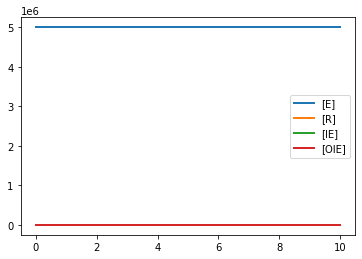

In [25]:
OIE = te.loada(OIE_model)
res = OIE.simulate(0, 10)
OIE.plot()

In [26]:
current_E = OIE.E

# pulse parasitemia
parasitemia = 0.4
IEs = current_E * parasitemia
OIE.IE = IEs
OIE.E = current_E - IEs
res2 = OIE.simulate(10,40)

In [27]:
tot_res = np.vstack((res, res2))
time = tot_res[::, 0]
species = tot_res[::,1:]
species.shape

(102, 4)

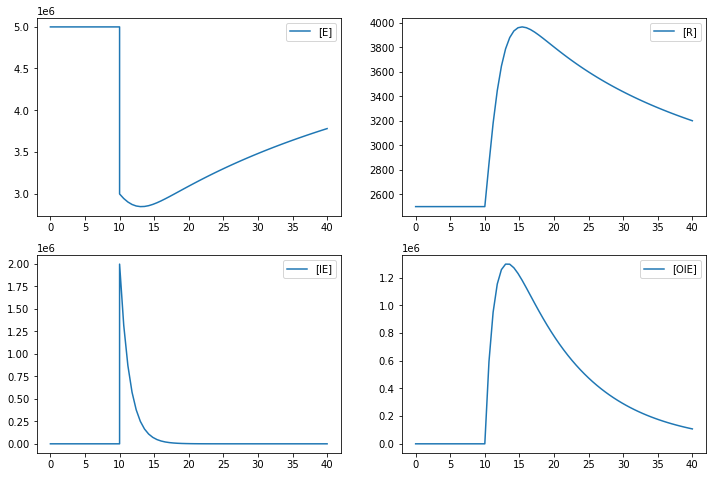

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
for i, label in enumerate(res.colnames[1:]):
    row = i // 2
    col = i % 2
    ax[row, col].plot(time, species[::, i], label=label)
    ax[row, col].legend()
plt.show()

In [29]:
E_res = species[::, 0]
R_res = species[::, 1]
IE_res = species[::, 2]
OIE_res = species[::, 3]
E_Vol = 80e-15 # 80 fL
OIE_Vol = 50e-15
Reti_Vol = 100e-15
IE_Vol = 80e-15
Hb_conc = 5e-3 # M
Hb_conc_IE = 3e-3
Hb_conc_OIE = 5e-3 * 0.3
Hb_conc_reti = 1e-3
molecular_mass = 64456 # g / mol
vol = 1e-6 # 1µl 
haematocrit= (E_Vol * E_res + IE_Vol * IE_res + OIE_Vol * OIE_res + Reti_Vol * R_res) / vol #0.4 # 40 %
hemoglobin_content =  molecular_mass * ((E_Vol * E_res * Hb_conc + IE_Vol * IE_res * Hb_conc_IE + 
                                         OIE_Vol * OIE_res * Hb_conc_OIE + Reti_Vol * R_res * Hb_conc_reti) / vol) # g/l
hemoglobin_content_g_dl =  hemoglobin_content / 10 # g/dl

In [30]:
data_df.columns

Index(['Tag', 'OIE ‰', 'infected ‰', 'Hb (g/l)', 'Retis ‰'], dtype='object')

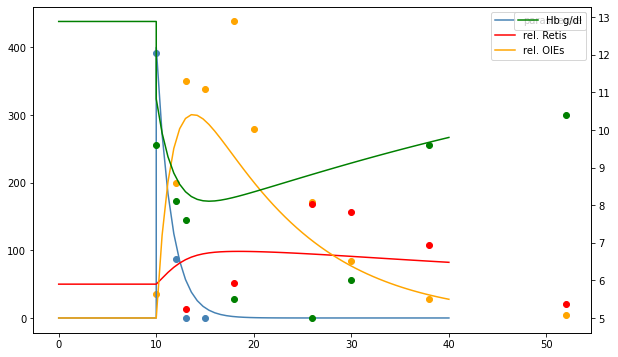

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax2 = ax.twinx()
ax.plot(time, 1e3*IE_res / (IE_res + E_res + R_res + OIE_res), label='parasitemie', color='steelblue')
ax.plot(time, 1e3*100*R_res / (IE_res + E_res + R_res + OIE_res), label='rel. Retis', color='red')
ax.plot(time, 1e3*OIE_res / (IE_res + E_res + R_res + OIE_res), label='rel. OIEs', color='orange')
ax.scatter(data_df['Tag']+9, data_df['infected ‰'], color='steelblue' )
ax.scatter(data_df['Tag']+9, data_df['OIE ‰'], color='orange' )
ax.scatter(data_df['Tag']+9, data_df['Retis ‰'], color='red' )
ax2.plot(time, hemoglobin_content_g_dl, color='green', label='Hb g/dl')
ax2.scatter(data_df['Tag'] + 9, data_df['Hb (g/l)'], color='green')


ax.legend()
ax2.legend()

plt.show()